# Elections - Notebook

### Imports

In [5]:
import time
import copy
import os

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from pabutools.election import (
    parse_pabulib,
    Cost_Sat,
    Cost_Sqrt_Sat,
    Effort_Sat,
    Cardinality_Sat,
)
from pabutools.rules import greedy_utilitarian_welfare, method_of_equal_shares
import pabutools.rules.maxwelfare as maxwelfare
from pabutools.rules.budgetallocation import BudgetAllocation
# from visualize import visualize_data

### Functionalities:
- print_outcome: print the outcome of the algorithm
- print_profile_info: print the information about the profile
- perform_election: perform the election with the given algorithm
- get_shares: get the shares based on Definition 1 from the paper
- get_average_capped_fair_share_ratio: get the average capped fair share ratio based on page 17 from the paper
- get_average_l1_distance: get the average L1 distance also based on page 17 from the paper


In [2]:
def print_outcome(outcome, name, instance):
    """
    Print the outcome of the algorithm.
    """
    print("Outcome of " + name + ":")
    cost = 0
    for projects in outcome:
        # print("Name: " + str(projects.name) + ", Cost: " + str(projects.cost))
        cost += projects.cost

    print(
        "Total cost: "
        + str(cost)
        + ". Budget left: "
        + str(instance.budget_limit - cost)
    )


def print_profile_info(instance, profile):
    """
    Print the information about the profile.
    """
    print(
        "Minimum Length of Ballots: " + str(profile.legal_min_length)
    )  # Imposed minimum length of the ballots in the profile
    print(
        "Maximum Length of Ballots: " + str(profile.legal_max_length)
    )  # Imposed maximum length of the ballots in the profile

    print(
        "Minimum Total Cost of Ballots: " + str(profile.legal_min_cost)
    )  # Imposed minimum total cost of the ballots in the profile
    print(
        "Maximum Total Cost of Ballots: " + str(profile.legal_max_cost)
    )  # Imposed maximum total cost of the ballots in the profile

    print("Budget limit is: " + str(instance.budget_limit))

    return


def perform_election(path, algorithm, algorithm_name, sat_class):

    instance, profile = parse_pabulib(path)
    # print_profile_info(instance, profile)

    start = time.time()
    outcome = algorithm(instance, profile, sat_class=sat_class)
    end = time.time()

    print_outcome(outcome, algorithm_name, instance)
    print(f"Time taken {algorithm_name}: {end - start:.2f} seconds")

    return outcome


def get_shares(outcome, profile, instance):
    """
    Shares based on Definition (and Example) 1 from the paper.
    Fair shares based on Definition 2 from the paper.
    """
    shares = []
    fair_shares = []

    # Dict for projects + their costs
    selected_projects = {project.name: float(project.cost) for project in outcome}

    # Dict for projects + their voters
    total_voters_per_project = {
        project.name: sum(project.name in ballot for ballot in profile)
        for project in outcome
    }

    # Get shares and fair shares for each voter
    for ballot in profile:
        agent_share = sum(
            selected_projects[project] / total_voters_per_project[project]
            for project in ballot
            if project in selected_projects
        )
        shares.append(agent_share)
        b_over_n = float(instance.budget_limit) / len(profile)
        fair_shares.append(min(b_over_n, agent_share))

    return shares, fair_shares


def get_average_capped_fair_share_ratio(shares, fair_shares):
    """
    Average capped fair share ratio based on page 17 from the paper.
    """

    num_agents = len(shares)
    sum_fair_shares = 0
    for i in range(num_agents):
        if shares[i] == 0:
            sum_fair_shares += 1
        else:
            sum_fair_shares += min(1, fair_shares[i] / shares[i])

    return sum_fair_shares / num_agents


def get_average_l1_distance(shares, fair_shares):
    """
    Average L1 distance also based on page 17 from the paper.
    """
    # TODO: This should be normalized
    num_agents = len(shares)
    return sum(abs(shares[i] - fair_shares[i]) for i in range(num_agents)) / num_agents

### Some intialization of the used structure
Saved as much information as possible (for now) so we have access to what we need.

In [4]:
elections_data = {}

def add_to_elections_data(data, dataset, rule, outcome, profile, instance):
    if dataset not in data:
        data[dataset] = {}
    shares, fair_shares = get_shares(outcome, profile, instance)
    data[dataset][rule] = {
        "outcome": outcome,
        "profile": profile,
        "instance": instance,
        "number_of_voters": len(profile),
        "number_of_projects": len(outcome),
        "cost": sum(project.cost for project in outcome),
        "budget_limit": instance.budget_limit,
        "budget_left": instance.budget_limit - sum(project.cost for project in outcome),
        "shares": shares,
        "fair_shares": fair_shares,
        "average_capped_fair_share_ratio": get_average_capped_fair_share_ratio(shares, fair_shares),
        "average_l1_distance": get_average_l1_distance(shares, fair_shares),
    }

## Perform the elections
This performs the election for all datasets in the "data" folder. It saves the data that is necessary for plotting in the right bin to the right measure, such that it can be retrieved later.

In [6]:
# paths = [
#     "2024-03-23_10-28-29_pabulib/netherlands_amsterdam_252_.pb",
#     "2024-03-23_10-28-29_pabulib/netherlands_amsterdam_285_.pb",
#     "2024-03-23_10-28-29_pabulib/netherlands_amsterdam_309_.pb",
#     "2024-03-23_10-28-29_pabulib/netherlands_amsterdam_523_.pb",
# ]

"""
I downloaded all data on Amsterdam from the PabuLib website and put it in the data folder.
"""
# Get all files in the data folder
directory = "data"
paths = []

for filename in os.listdir(directory):
    paths.append(os.path.join(directory, filename))

start = time.time()

# Run the elections for each file
for path in paths:
    print(f"---- Running {path} ----")
    # path = "2024-03-23_10-28-29_pabulib/netherlands_amsterdam_252_.pb"  # set this variable
    instance, profile = parse_pabulib(path)

    # Greedy
    outcome = perform_election(path, greedy_utilitarian_welfare, "Greedy", Cost_Sat)
    add_to_elections_data(elections_data, path, "Greedy", outcome, profile, instance)

    # MES Cost_Sat
    outcome = perform_election(path, method_of_equal_shares, "MES Cost_Sat", Cost_Sat)
    add_to_elections_data(elections_data, path, "MES Cost_Sat", outcome, profile, instance)

    # MES Cost_Sqrt_Sat
    outcome = perform_election(
        path, method_of_equal_shares, "MES Cost_Sqrt_Sat", Cost_Sqrt_Sat
    )
    add_to_elections_data(elections_data, path, "MES Cost_Sqrt_Sat", outcome, profile, instance)

    # MES Effort_Sat
    # outcome = perform_election(
    #     path, method_of_equal_shares, "MES Effort_Sat", Effort_Sat
    # )
    # add_to_elections_data(elections_data, path, "MES Effort_Sat", outcome, profile, instance)

    # MES Cardinality_Sat
    outcome = perform_election(
        path, method_of_equal_shares, "MES Cardinality_Sat", Cardinality_Sat
    )
    add_to_elections_data(elections_data, path, "MES Cardinality_Sat", outcome, profile, instance)

---- Running data/netherlands_amsterdam_523_.pb ----
Outcome of Greedy:
Total cost: 145000. Budget left: 10000
Time taken Greedy: 0.01 seconds
Outcome of MES Cost_Sat:
Total cost: 111400. Budget left: 43600
Time taken MES Cost_Sat: 0.01 seconds
Outcome of MES Cost_Sqrt_Sat:
Total cost: 56400. Budget left: 98600
Time taken MES Cost_Sqrt_Sat: 0.02 seconds
Outcome of MES Cardinality_Sat:
Total cost: 56400. Budget left: 98600
Time taken MES Cardinality_Sat: 0.00 seconds
---- Running data/netherlands_amsterdam_324_.pb ----
Outcome of Greedy:
Total cost: 30000. Budget left: 0
Time taken Greedy: 0.07 seconds
Outcome of MES Cost_Sat:
Total cost: 13000. Budget left: 17000
Time taken MES Cost_Sat: 0.06 seconds
Outcome of MES Cost_Sqrt_Sat:
Total cost: 13000. Budget left: 17000
Time taken MES Cost_Sqrt_Sat: 0.23 seconds
Outcome of MES Cardinality_Sat:
Total cost: 13000. Budget left: 17000
Time taken MES Cardinality_Sat: 0.05 seconds
---- Running data/netherlands_amsterdam_287_.pb ----
Outcome of 

## Processing data
Some functionalities to get a better look at the data

In [10]:
def get_elections_for_dataset(dataset):
    return elections_data[dataset]

def get_elections_for_rule(data, rule):
    result = {}
    for dataset, elections in data.items():
        if rule in elections:
            if dataset not in result:
                result[dataset] = {}
            result[dataset][rule] = elections[rule]
    return result

def get_elections_by_projects_range(data, min_projects, max_projects):
    result = {}
    for dataset, elections in data.items():
        for rule, details in elections.items():
            if min_projects <= details["number_of_projects"] <= max_projects:
                if dataset not in result:
                    result[dataset] = {}
                result[dataset][rule] = details
    return result

def get_elections_per_rule_per_project_range(data, rule, min_projects, max_projects):
    result = {}
    for dataset, elections in data.items():
        if rule in elections:
            if min_projects <= elections[rule]["number_of_projects"] <= max_projects:
                if dataset not in result:
                    result[dataset] = {}
                result[dataset][rule] = elections[rule]
    return result

## Normalizing the data
The principle that should be applied here are as stated in the paper on page 16 Figure 3: "Results are normalised by the optimum value achievable in each instance." Therefore, we should divide the results by the optimum value achievable.

In the paper they mention on page 17 that "For each PB instance we computed via integer linear programs budget allocations yielding the optimal average capped fair share ratio and L1 distance to FS." The pabutools documentation says the ILP-solver should be provided. However, this is actually nowhere to be found in the code. Therefore based on the logic as found in the libary code at: https://pbvoting.github.io/pabutools/_modules/pabutools/rules/maxwelfare.html#MaxAddUtilWelfareAlgo, we tried to implement this ILP by manually copying the code from this file. The used library was, however, incompatible with our laptops and therefore this proved impossible to do.


In [33]:
# Since normalisation with optimum is not possible, we will normalise with the miminum value (as optimum)
# TODO: this does now work, how to normalise?
for dataset in elections_data:
    min_c = 10000
    min_l = 10000
    for rule in elections_data[dataset]:
        c = elections_data[dataset][rule]["average_capped_fair_share_ratio"]
        l = elections_data[dataset][rule]["average_l1_distance"]
        if c < min_c:
            min_c = c
        if l < min_l:
            min_l = l
    print(f"Minimum capped fair share ratio: {min_c}")
    print(f"Minimum l1 distance: {min_l}")
    # 1 should be the best value, but the smaller the l1_distance, the better
    # The same applies for the capped fair share ratio
    # So we will normalise by dividing by the minimum value
    for rule in elections_data[dataset]:
        elections_data[dataset][rule]["normalized_average_capped_fair_share_ratio"] = elections_data[dataset][rule]["average_capped_fair_share_ratio"] / min_c
        elections_data[dataset][rule]["normalized_average_l1_distance"] = elections_data[dataset][rule]["average_l1_distance"] / min_l

Minimum capped fair share ratio: 0.9025965330402037
Minimum l1 distance: 0.0


ZeroDivisionError: float division by zero

## After elections, data can be visualized here
Attempt to make it look like in the paper.

In [46]:
# Visualize the data
# Bins: 2 - 7 8 - 13 14 - 19 20 - 30 31 - 65
bins = [2, 8, 14, 20, 31]
bin_names = ["2 - 7", "8 - 13", "14 - 19", "20 - 30", "31 - 65"]
rules = ["Greedy", "MES Cost_Sat", "MES Cost_Sqrt_Sat", "MES Cardinality_Sat"] # Effort not yet included

# Plot the average capped fair share ratio per bin, for each rule, we should plot
# the average and standard deviation accross all datasets
def plot_average_normalized_capped_fair_share_per_bin(data, bins):
    for rule in rules:
        averages = []
        stds = []
        for i in range(len(bins)):
            min_projects = bins[i]
            try: # For final bin
                max_projects = bins[i + 1]
            except IndexError:
                max_projects = 1000
            elections = get_elections_per_rule_per_project_range(data, rule, min_projects, max_projects)
            if len(elections) > 0:
                plot_data = [elections[dataset][rule]["average_capped_fair_share_ratio"] for dataset in elections]
                averages.append(np.mean(plot_data))
                stds.append(np.std(plot_data))
            else: # Sometimes no data in bin, this should not show up in the plot
                averages.append(0)
                stds.append(0)
        plt.errorbar(bin_names, averages, yerr=stds, label=rule)
    plt.xlabel("Number of projects")
    plt.ylabel("Average normalized capped fair share ratio")
    plt.legend()
    plt.show()

def plot_average_normalized_l1_distance_per_bin(data, bins):
    # Thiis pretty much a copy of what I did above
    for rule in rules:
        averages = []
        stds = []
        for i in range(len(bins)):
            min_projects = bins[i]
            try: # For final bin
                max_projects = bins[i + 1]
            except IndexError:
                max_projects = 1000
            elections = get_elections_per_rule_per_project_range(data, rule, min_projects, max_projects)
            if len(elections) > 0:
                plot_data = [elections[dataset][rule]["average_l1_distance"] for dataset in elections]
                averages.append(np.mean(plot_data))
                stds.append(np.std(plot_data))
            else: # Sometimes no data in bin, this should not show up in the plot
                averages.append(0)
                stds.append(0)
        plt.errorbar(bin_names, averages, yerr=stds, label=rule)
    plt.xlabel("Number of projects")
    plt.ylabel("Average normalized L1 distance")
    plt.legend()
    plt.show()
    

    

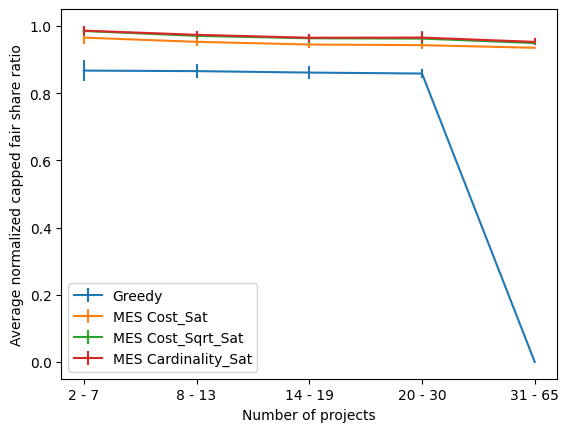

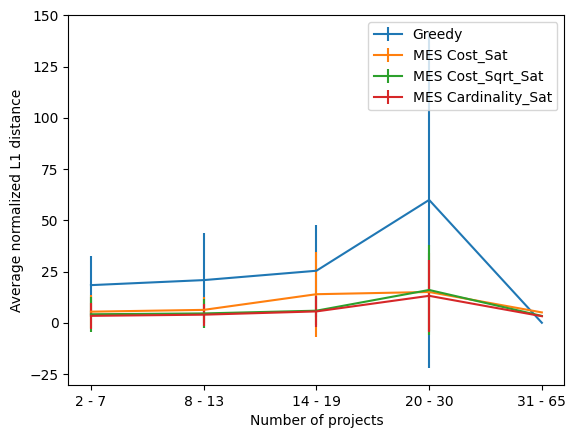

In [47]:
plot_average_normalized_capped_fair_share_per_bin(elections_data, bins)
plot_average_normalized_l1_distance_per_bin(elections_data, bins)


In [49]:
# How much budget is left on average per rule?

def plot_budget_left_per_rule(data):
    averages = []
    stds = []
    for rule in rules:
        plot_data = [float(data[dataset][rule]["budget_left"]) for dataset in data]
        averages.append(np.mean(plot_data))
        stds.append(np.std(plot_data))
    plt.errorbar(rules, averages, yerr=stds)
    plt.xlabel("Rule")
    plt.ylabel("Average budget left")
    plt.show()

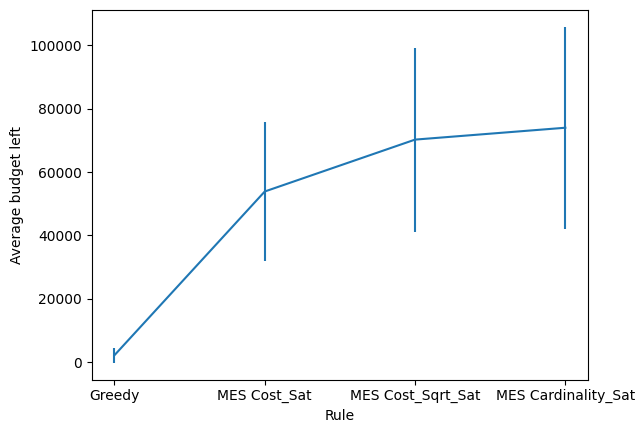

In [50]:
plot_budget_left_per_rule(elections_data)
# TODO: fix the budget left for MES